In [1]:
import sys, os

sys.path.insert(0, '../../../node2vec')
sys.path.insert(0, '../..')


# checking if imports working
import node2vecs
from dataset import pokec_data

In [2]:
from urllib.request import urlopen
from zipfile import ZipFile

source_data_url = "http://www-personal.umich.edu/~mejn/netdata/polbooks.zip"

tmp_gml_file = "/tmp/data"
zipresp = urlopen(source_data_url)
tempzip = open("/tmp/polbooks.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("/tmp/polbooks.zip")
zf.extractall(path = tmp_gml_file)
zf.close()

graph_data_file = tmp_gml_file + "/" + "polbooks.gml"

In [3]:
import networkx as nx 
import numpy as np 
from scipy import sparse 

G = nx.read_gml(graph_data_file)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)

deg = np.array(A.sum(axis=1)).reshape(-1)

(-1.2088812266416689,
 1.1982262422766097,
 -0.6428872218752846,
 0.7136979322437104)

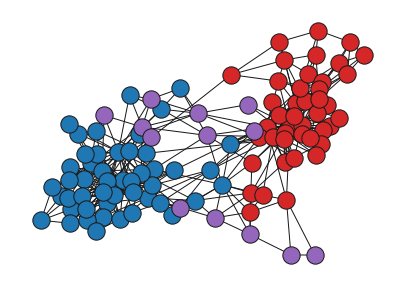

In [4]:
# %%
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

pos = nx.spring_layout(G)
node_opts = {"edgecolors": "k", "linewidths": 1.0, "ax":ax}

nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 0)[0], node_color="tab:blue", **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 1)[0], node_color="tab:red", **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 2)[0], node_color="tab:purple", **node_opts
)
nx.draw_networkx_edges(G, pos)
ax.axis("off")

In [5]:
#Parameters 
dim = 32
n_nodes = A.shape[0]
device = "cpu"

In [6]:
# Set up the embedding model
import node2vecs 

model = node2vecs.Word2Vec(
    vocab_size=n_nodes + 1,
    embedding_size=dim,
    padding_idx=n_nodes,
    learn_outvec=False, # Set True to learn out vector. Otherwise, the out-vector is copied from in-vector.
)
model = model.to(device)
# We use the most non-infomative random networks, where 
# every pair of nodes is connected with the same probability 
noise_sampler = node2vecs.utils.node_sampler.ErdosRenyiNodeSampler()
noise_sampler.fit(A) # Train the noise sampler

# We sample triplet of nodes containing one negative sample per positive sample.
loss_func = node2vecs.Node2VecTripletLoss(n_neg=1)
dataset = node2vecs.TripletDataset(
    adjmat=A,
    window_length=1,
    noise_sampler=noise_sampler,
    padding_id=n_nodes,
    buffer_size=256,
    context_window_type="double",
    epochs=1,
    negative=1,
    p = 1,
    q = 1, 
    num_walks = 20,
    walk_length = 80,
)

In [7]:
# Generate embedding 
node2vecs.train(
    model=model,
    dataset=dataset,
    loss_func=loss_func,
    batch_size=256,
    device=device,
    learning_rate=1e-3,
    num_workers=1,
)
model.eval()

# Retrieve the embedding vector. We use the in-vector. 
emb_biased = model.ivectors.weight.data.cpu().numpy()[:n_nodes, :]

100%|█████████████████████████████| 657/657 [00:03<00:00, 171.87it/s, loss=1.18]


(-1.5454532325267791,
 1.6215076863765716,
 -0.9061417430639267,
 1.6851995438337326)

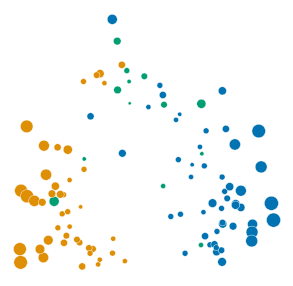

In [8]:
from sklearn.decomposition import PCA
import pandas as pd 

plot_data = []
deg = np.array(A.sum(axis=0)).reshape(-1)
xy = PCA(n_components=2).fit_transform(emb_biased)
plot_data  = pd.DataFrame(
        {
            "x": xy[:, 0],
            "y": xy[:, 1],
            "group": group_ids,
            "model": "Biased",
            "degree": deg,
        }
    )

# %%
sns.set_style('white')
sns.set(font_scale=1.0)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data = plot_data, x = "x", y = "y", hue = "group", size = "degree", sizes=(10, 200), palette = sns.color_palette("colorblind", n_colors=3), ax = ax)
ax.legend().remove()
ax.axis("off")

In [9]:
def generate_embedding(A, dim, noise_sampler):
    model = node2vecs.Word2Vec(
        vocab_size=n_nodes + 1,
        embedding_size=dim,
        padding_idx=n_nodes,
        learn_outvec=False, # Set True to learn out vector. Otherwise, the out-vector is copied from in-vector.
    )
    model = model.to(device)
    noise_sampler.fit(A) # Train the noise sampler
    
    # We sample triplet of nodes containing one negative sample per positive sample.
    loss_func = node2vecs.Node2VecTripletLoss(n_neg=1)
    dataset = node2vecs.TripletDataset(
        adjmat=A,
        window_length=1,
        noise_sampler=noise_sampler,
        padding_id=n_nodes,
        buffer_size=256,
        context_window_type="double",
        epochs=1,
        negative=1,
        p = 1,
        q = 1, 
        num_walks = 20,
        walk_length = 80,
    )
    # Generate embedding 
    node2vecs.train(
        model=model,
        dataset=dataset,
        loss_func=loss_func,
        batch_size=256,
        device=device,
        learning_rate=1e-3,
        num_workers=1,
    )
    model.eval()
    
    # Retrieve the embedding vector. We use the in-vector. 
    return model.ivectors.weight.data.cpu().numpy()[:n_nodes, :]

In [10]:
config_noise_sampler = node2vecs.utils.node_sampler.ConfigModelNodeSampler()
sbm_noise_sampler=node2vecs.utils.node_sampler.SBMNodeSampler(
   group_membership=group_ids, window_length=1
)

In [11]:
emb_config = generate_embedding(A, dim, config_noise_sampler)
emb_sbm = generate_embedding(A, dim, sbm_noise_sampler)

# calculate ROC AUC score here


100%|█████████████████████████████| 657/657 [00:01<00:00, 333.10it/s, loss=1.26]


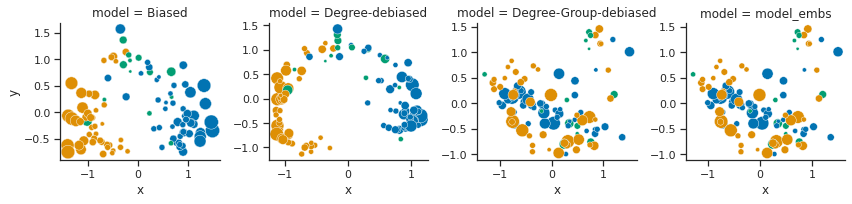

In [12]:
plot_data_all = [plot_data]
embs = {
    "Biased":emb_biased,
    "Degree-debiased":emb_config,
    "Degree-Group-debiased":emb_sbm
}
deg = np.array(A.sum(axis=0)).reshape(-1)
for k, emb in embs.items():
    emb = embs[k]
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": group_ids,
                "model": k,
                "degree": deg,
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(7,5))

g = sns.FacetGrid(
    data=plot_data_all,
    col="model",
    sharex=False,
    sharey=False,
    
)

g.map(sns.scatterplot, "x", "y", "group", "degree", sizes=(10, 200), palette = sns.color_palette("colorblind", n_colors=3))